# Phase 3: Congruence via Entity Vector Similarity

In this notebook, we calculate the cosine similarity measure between vectors of each candidate. The vectors will be retrieved from Wikipedia2vec's pre-trained API, which creates vectors for the entire Wikipedia page including its relational links. Comparing two vectors in this way thus lets us make a statement about similar pages and update our prior confidence based on that.

#### Using Prior Confidence

In Phase 3, we calculate congruence between candidates in pools for mentions in the same sentence. We then update these congruence metrics using prior confidence from Phase 2. This should adjust our pool by discounting congruence using the prior knowledge we have of the calculated similarity. In this notebook, we import prior knowledge generated from Anchor Link statistics and weight those with our numerical calculations from congruence. We demonstrate the performance gains of directly incorporating prior confidence.

### Import Packages

In [1]:
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

# Progress bar
from tqdm import tqdm

In [2]:
# Base path to input
preds_path = '../../predictions/'

# Load data
full_mentions = pd.read_csv(os.path.join(preds_path, "anchortext_frequency.csv"), delimiter=",")
full_mentions.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 21347120, 9477, 1882861]","[458, 46, 211593, 1396, 363404]","['European_Union', 'Europe', 'Eu,_Seine-Mariti...","[0.9227799, 0.024651, 0.020196, 0.005346, 0.00..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 11884, 152735, 21212, 12674]","[183, 188, 42884, 7318, 43287]","['Germany', 'German_language', 'Germans', 'Naz...","[0.4192066, 0.2893363, 0.1470461, 0.03832, 0.0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[31717, 19097669, 13530298, 4721, 158019]","[145, 842438, 23666, 8680, 161885]","['United_Kingdom', 'British_people', 'Great_Br...","[0.6101256, 0.1146913, 0.0681775, 0.0366451, 0..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"


### Parse Saved Candidate Pool

Candidate pools when exported to csv are stored as the string of the list. The below function parses the string back into a list with proper formatted values.

In [3]:
# Demonstrate that list is string
type(full_mentions['candidate_pool_page_ids'][0])

str

In [4]:
# Function to parse list as string
def parse_list_string(list_string, value_type=int):
    
    parsed_list = []
    
    # If candidate pool is empty
    if list_string == "[]" or isinstance(list_string, float):
        pass
    # Else parse
    else:
        # Parses lists of titles as strings
        if value_type==str:
            # Eliminate bracket and parenthesis on either side, split by comma pattern
            parsed_list = re.split("', '|\", \"|', \"|\", \'", list_string[2:-2])

        # Parses lists of IDs as ints
        elif value_type==int:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(int, list_string[1:-1].split(', ')))
        elif value_type==float:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(float, list_string[1:-1].split(', ')))
            
        
    return parsed_list


In [5]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_list_string(full_mentions['candidate_pool_titles'][0], value_type=str)

['European_Union',
 'Europe',
 'Eu,_Seine-Maritime',
 'Europium',
 'Citizenship_of_the_European_Union']

In [6]:
# Manually test function
parse_list_string(full_mentions['candidate_pool_page_ids'][0], value_type=int)

[9317, 9239, 21347120, 9477, 1882861]

In [7]:
# Manually test function
parse_list_string(full_mentions['candidate_pool_page_ids'][13], value_type=int)

[]

In [8]:
# Manually test function
parse_list_string(full_mentions['candidate_pool_priors'][0], value_type=float)

[0.9227799, 0.024651, 0.020196, 0.005346, 0.002079]

In [9]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=str)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])

column = 'candidate_pool_page_ids'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=int)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])


column = 'candidate_pool_item_ids'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=int)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])


column = 'candidate_pool_titles'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=str)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])

column = 'candidate_pool_priors'
print("Before", full_mentions[column][3])
parsed_candidate_pool = full_mentions[column].apply(parse_list_string, value_type=float)
full_mentions[column] = parsed_candidate_pool
print("After", full_mentions[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 9643132, 56873217]
After [56783206, 9643132, 56873217]
Before [2073954, 7172840, 26634508]
After [2073954, 7172840, 26634508]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
Before [0.5, 0.3, 0.2]
After [0.5, 0.3, 0.2]
CPU times: user 256 ms, sys: 14.2 ms, total: 271 ms
Wall time: 270 ms


## Retrieve Entity Vectors from Wikipedia2Vec

For provided wikipedia pages, we retrieve a representative entity vector from Wikipedia2vec. This involves passing the normalized title into their get_entity_vector() function. We default to using 100d pre-trained embeddings due to the easier computational requirements, but tested results using higher dimensions as well.

In [10]:
# Package
from wikipedia2vec import Wikipedia2Vec

In [11]:
%%time
# Load unzipped pkl file with word embeddings
w2v = Wikipedia2Vec.load("../../embeddings/enwiki_20180420_100d.pkl")

CPU times: user 94.8 ms, sys: 122 ms, total: 217 ms
Wall time: 289 ms


### Assess Wikipedia2Vec Query Success

We need to measure what percent of candidates in our candidate pools successfully return a vector from Wikipedia2Vec. This should conceivably be 100% given we're passing known Wikipedia pages into this package trained over Wikipedia pages, but there may be some drop-off due to different creation dates or unique names without pages.

In [12]:
# Define text normalization function
def normalize_text(text):
    """
    We define normalized in this notebook as:
    - strip whitespace
    - Spaces, not underlines
    """
    return str(text).strip().replace("_", " ")

In [13]:
# Iterate over candidate pool titles to see what can be returned

found_entity = 0
searched_entity = 0

for i in tqdm(range(len(full_mentions))):
    
    # Retrieve candidate pool
    candidate_pool = full_mentions['candidate_pool_titles'][i]
    
    # Query for each candidate
    for candidate in candidate_pool:
        # Normalize candidate title to form necessary to input into Wikipedia2vec
        candidate = normalize_text(candidate)
        
        # Query Wikipedia2vec get_entity_vector()
        try:
            entity_vector = w2v.get_entity_vector(candidate)
        except KeyError:
            entity_vector = None
        
        # Check if result
        if entity_vector is not None:
            found_entity += 1
        
        # Increment count
        searched_entity += 1

print(f"Wikipedia2vec returned an entity vector for {round(found_entity/searched_entity*100,3)}% of {searched_entity:,} searches")

100%|██████████| 21810/21810 [00:01<00:00, 16973.95it/s]

Wikipedia2vec returned an entity vector for 94.438% of 65,248 searches


## Understand Sentence Properties

First, let's get a sense for what the upper bound of congruent calculations might be per sentence as well as the distribution of counts and average priors.

In [14]:
# What is the maximum number of congruent entities in a single sentence
max(full_mentions['congruent_mentions'].apply(len))

25

25 is expected given we filtered to only sentences containing less than this in Phase 1.

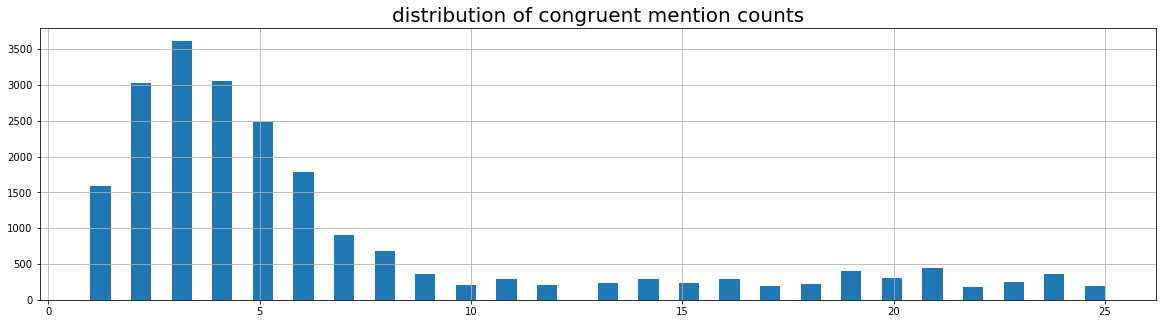

In [15]:
# What is the distribution of congruent mention counts
plt.figure(figsize=(20,5))
full_mentions['congruent_mentions'].apply(len).hist(bins=50)
plt.title("distribution of congruent mention counts", size=20)
plt.show()

Most sentences occur in a near normal distribution around 3 full mentions, though this distribution then extends far to the right up to 25 full mentions. Next, let's get a sense for the average ranking of the right answer.

In [16]:
# Prepare tracking metrics
correct_answer_rank = []
correct_answer_prior = {0:[],1:[],2:[],3:[],4:[]}
correct_answer_not_present = 0
correct_answer_null = 0

# Iterate over whole dataframe
for i in tqdm(range(len(full_mentions))):
    row = full_mentions.iloc[i]
    correct_answer = row['wikipedia_page_ID']
    if isinstance(row['wikipedia_title'], float):
        correct_answer_null += 1
    else:
        try:
            correct_rank = row['candidate_pool_page_ids'].index(correct_answer)
            correct_answer_rank.append(correct_rank)
            correct_answer_prior[correct_rank].append(row['candidate_pool_priors'][correct_rank])
        except ValueError:
            correct_answer_not_present += 1

print(f"Correct answer null {round(correct_answer_null/len(full_mentions)*100,1)}% of the time.")
print(f"Correct answer not present in candidate pool {round(correct_answer_not_present/len(full_mentions)*100,1)}% of the time.")

100%|██████████| 21810/21810 [00:02<00:00, 7775.48it/s]

Correct answer null 27.0% of the time.
Correct answer not present in candidate pool 7.1% of the time.


In [17]:
# Calculate coverage of candidate pools for full mentions with known true values
total_len = len(full_mentions[full_mentions['wikipedia_page_ID'].notnull()])
print(f"We have {round((total_len - correct_answer_not_present) / total_len * 100,3)}% coverage.")

We have 90.263% coverage.


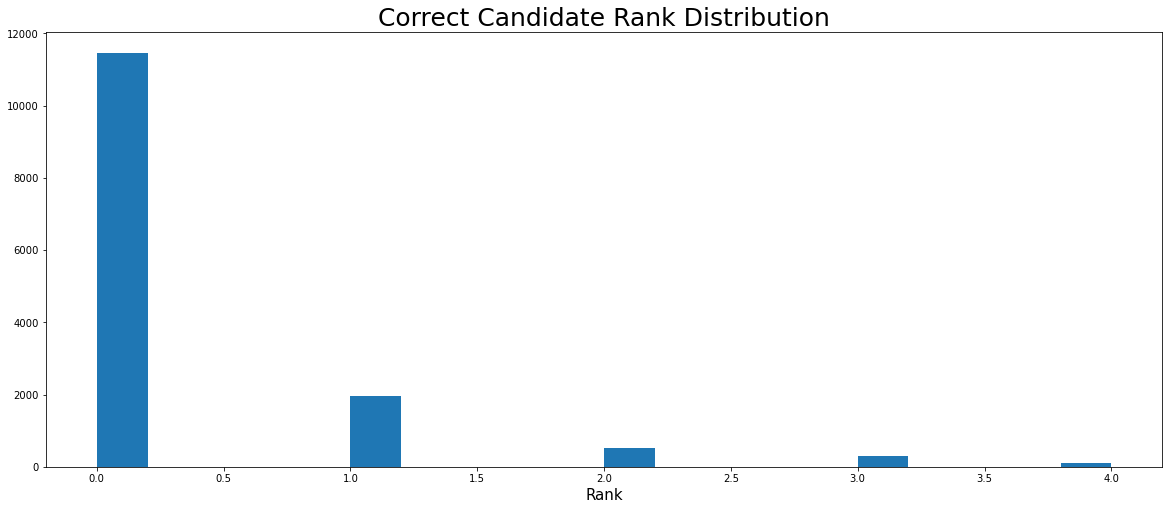

In [18]:
# Plot rank distribution
plt.figure(figsize=(20,8))
plt.hist(correct_answer_rank, bins=20)
plt.title("Correct Candidate Rank Distribution", size=25)
plt.xlabel("Rank", size=15)
plt.show()

In [19]:
# Provide rank quantities
pd.Series(correct_answer_rank).value_counts()

0    11466
1     1970
2      518
3      300
4      114
dtype: int64

In [20]:
# Calculate mean prior confidence for each rank
for k,v in correct_answer_prior.items():
    print(f"Correct Candidate Rank: {k} - Average Prior Confidence: {round(np.mean(v),5)} - Median Prior Confidence: {round(np.median(v),5)}")

Correct Candidate Rank: 0 - Average Prior Confidence: 0.88993 - Median Prior Confidence: 0.96091
Correct Candidate Rank: 1 - Average Prior Confidence: 0.18542 - Median Prior Confidence: 0.17061
Correct Candidate Rank: 2 - Average Prior Confidence: 0.07883 - Median Prior Confidence: 0.07267
Correct Candidate Rank: 3 - Average Prior Confidence: 0.04203 - Median Prior Confidence: 0.04132
Correct Candidate Rank: 4 - Average Prior Confidence: 0.02247 - Median Prior Confidence: 0.01424


When limited to sentences with 25 congruent mentions or less, 79.8% are in First Place and 13.7% are in Second, totaling 93.5% in our top two positions. Our first place candidates have median prior confidence of 0.96, but mean confidence of 0.889, suggesting that for most mentions we are highly confident in its first option, but a few are much lower and more uncertain, bringing the mean down (like a 50/50 estimate). Conversely, in second place, median is 0.17 but mean is 0.185, further suggesting those 50/50 estimates for some mentions bringing the mean up.

Our hope is that congruence will be able to clarify those more evenly split prior values.

## Calculate Congruence Metric between Congruent Entities

In order to allow this to become recursive for N many tables, we will need to capture a congruence table for every candidate pool to every other candidate pool in a two-level dictionary so you can retrieve values using `matrix[3][1]`. This would entail duplication except to save that, we sort by value so you always search [small][large]. This saves us computation and storage. To see a sequential example of our logic, scroll to the end of this notebook. Below is our function-based implementation of our pipeline.

### Define Functions to Create Modular Congruent Pipeline

In [21]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        if verbose: print(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100) # Note: this must change if using higher dimensional embeddings
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    # Handle case where candidate pool is empty from prior phase
    # Add 3 arrays of zeros of same dimensionality as embeddings
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [22]:
# Define function to retrieve entity vectors
def create_entity_vector_dict(sentence_mention_ids, single_sentence_df, verbose=False):
    """
    Function iterates over a provided list of congruent mentions,
    finds the associated candidate pool for each mention
    and returns the candidate pool in vector representation
    """
    # Save vectors in dictionary
    vector_dict = {}
    
    # For each full mention we are analyzing in the contextual domain
    for m in sentence_mention_ids:
        
        # Retrieve candidate pool titles
        candidate_pool_titles = single_sentence_df['candidate_pool_titles'][m]
        if verbose: print(candidate_pool_titles)
        
        # Convert candidate pool titles to candidate pool vectors
        candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=verbose)
        
        # Save candidate pool vectors to dictionary
        vector_dict[m] = candidate_pool_vectors
    
    if verbose:
        print(vector_dict.keys())
        for k in vector_dict.keys():
            print(len(vector_dict[k]))

    return vector_dict

In [23]:
# Define function to calculate congruent metric for each candidate in every mention's candidate pool
def get_congruence_dict(vector_dict, sentence_mention_ids, verbose=False):
    """
    Function to return congruence metric calculations between all candidates for all mentions
    Input:
    - vector_dict
    - Sentence Mentions Numerical Representation: Integers representing congruent mentions in a context domain
    Outputs:
    - Dictionary with congruence metric calculations for everyone
    """
    
    ## Save congruence metrics in a two-level dictionary
    # Create first-level dictionary to be returned
    congruence_dict = {}
    
    # Always work low numbers to high without duplicate comparison
    m = 0
    while m < len(sentence_mention_ids)-1:
        
        # Create second-level congruence metric dictionary
        m_dict = {}

        # Compare eaech mention against mentions after it
        for n in sentence_mention_ids[m+1:]:
            if verbose: print(f"Comparing mentions {m} & {n}")
            # Calculate congruence metric - cosine similarity
            congruence_metric = cosine_similarity(vector_dict[m], vector_dict[n])
            # Save congruence metric to second-level dictionary
            m_dict[n] = congruence_metric
        
        # Save second-level dictionary to first-level
        congruence_dict[m] = m_dict
        
        # Increment mention
        m += 1
    
#     if verbose: print(congruence_dict)
    return congruence_dict

In [24]:
# Define function to combine mention probabilities
def combine_probabilities(mid_1, mid_2, sentence_probabilities):
    """
    Function takes two mentions (numerically represented),
    finds their candidate pool probabilities,
    and combines them using the chosen logic,
    returning a matrix of combined pair-wise probabilities
    """
    # Prepare matrix to return
    weights_matrix = []
    
    # Combine every candidate's probability for one mention with each for the second
    for a in sentence_probabilities[mid_1]:
        weights_row = []
        for b in sentence_probabilities[mid_2]:
            
            ## Combination logic
            weights_row.append(np.mean([a, b])) # Take mean of two prior probabilities
        
        weights_matrix.append(weights_row)
        
    return weights_matrix

In [25]:
# Define function to create a weighted dictionary from priors
def create_weighted_dict(sentence_mention_ids, single_sentence_df, verbose=False):
    """
    Function iterates over a provided list of congruent mentions,
    finds the associated candidate pool prior probabilities for each mention
    and returns a dictionary for the combined probability of every pair of candidates
    """
    # Save weights in dictionary
    weights_dict = {}
    
    # Always work low numbers to high without duplicate comparison
    m = 0
    while m < len(sentence_mention_ids)-1:
        
        # Create second-level weights dictionary
        w_dict = {}
        
        # Compare each mention probabilities against mentions after it
        for n in sentence_mention_ids[m+1:]:
            if verbose: print(f"Comparing mentions {m} & {n}")
            # Return candidate pool probabilities
            weights_matrix = combine_probabilities(m, n, single_sentence_df['candidate_pool_priors'])
            if not weights_matrix: # Handles error where candidate pool is empty
                weights_matrix = [0.0]
            # Save weights matrix to second-level dictionary
            w_dict[n] = weights_matrix
        
        # Save second-level dictionary to first-level
        weights_dict[m] = w_dict
        
        # Increment mention
        m += 1
                
    return weights_dict

In [26]:
# Define function to combine congruence and prior weights
def combine_congruence_priors(sentence_mention_ids, congruence_dict, weights_dict, verbose=False):
    """
    Function takes two dictionaries representing recursive metric calculations,
    Multiplies them element-wise together,
    Returns the updated table
    """
   # Combine congruence with prior weights in first-level dictionary
    weighted_congruence = {}
    
    # Always work low numbers to high without duplicate comparison
    m = 0
    while m < len(sentence_mention_ids)-1:
        
        # Create second-level dictionary
        w_c_dict = {}
        
        # Compare each mention probabilities against mentions after it
        for n in sentence_mention_ids[m+1:]:
            try:
                weighted_table = congruence_dict[m][n] * np.array(weights_dict[m][n])
            except ValueError: # Handles error when candidate pool is empty
                weighted_table = congruence_dict[m][n]
            w_c_dict[n] = weighted_table
        
        # Save second-level dictionary to first-level
        weighted_congruence[m] = w_c_dict
        
        # Increment mention
        m += 1
    
    return weighted_congruence

In [27]:
### Standardize on form lookup always row then column
def get_most_congruent_pair(congruence_matrix, verbose=False):
    """
    This function takes a congruence matrix and returns the indices
    of the two most congruent candidates using your chosen metric.
    These indices can be plugged back into the candidate pool lists
    to determine which candidates are most similar.
    """
    # Get max values for every row
    max_row_values = congruence_matrix.max(axis=1)
    max_row_idxs = congruence_matrix.argmax(axis=1)
    
    # Get overall max value and the row it is in
    max_value = max_row_values.max()
    max_row_idx = max_row_values.argmax()
    
    # Get column max value is in
    max_column_idx = max_row_idxs[max_row_idx]
    
    return (max_row_idx, max_column_idx), max_value

In [28]:
# Function to retrieve the most congruent pair amongst remaining mentions
def find_most_congruent_pair(mention_predictions, mentions_remaining, congruence_dict, verbose=False):
    """
    Function to search the congruence matrices for mentions without predictions
    and return the most congruent pair of candidates and associated mentions
    """
    
    # Start with empty most_congruent_pair
    # (Candidate Pair, Congruence Metric), (Mention A, Mention B)
    most_congruent_pair = (((None, None), 0.0), (0, 0))
    
    # Assess whether first pass or recursive pass
    if len(mention_predictions) == 0:

        # First pass        
        for m in mentions_remaining:
            for n in mentions_remaining[m+1:]:

                # Get most congruent pair in one matrix
                congruent_pair = get_most_congruent_pair(congruence_dict[m][n], verbose=verbose)

                if verbose:
                    print(f"Comparing {m} & {n}")
                    print("Congruent Pair: ", congruent_pair)
                    print("Current Most Congruent: ", most_congruent_pair)
                
                if congruent_pair[1] > most_congruent_pair[0][1]:
                    # Save most congruent candidate pair and mentions
                    most_congruent_pair = congruent_pair, (m, n)

    elif len(mention_predictions) > 0:
        
        # Second+, recursive pass
        for m in mention_predictions.keys():
            for n in mentions_remaining:
                
                # Becauase we always assume search small mention to large to save computation/storage,
                # we must sort incrementing variables to be in increasing order for query
                m_tmp, n_tmp = np.sort((m, n))
                
                # Get most congruent pair in one matrix
                congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp], verbose=verbose)
                
                if verbose:
                    print(f"Comparing {m_tmp} & {n_tmp}")
                    print("Congruent Pair: ", congruent_pair)
                    print("Current Most Congruent: ", most_congruent_pair)
                    
                if congruent_pair[1] > most_congruent_pair[0][1]:
                    # Save most congruent candidate pair and mentions
                    most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
                
    if verbose: print("Final Most Congruent Pair: ", most_congruent_pair)
    return most_congruent_pair

### Congruent Predictions Function

This is our main function that takes a sentence ID, calculates congruence for all candidates, updates the prior confidence from Phase 3 with that congruence and selects predictions iteratively based on that final number.

In [29]:
# Define function to calculate congruent predictions
def get_congruent_predictions(sentence_id, dataframe, with_priors=True, verbose=False):
    """
    Function to calculate congruence metrics over a set of entity full mentions
    and return the predicted candidates based on the congruent metric
    Input:
    - Sentence ID used to filter dataframe
    - Dataframe over which to process
    Output:
    - Prediction for each entity mention
    """
    
    # Filter to dataframe representing single sentence
    # Drop duplicates necessary for sentences with the same mention included twice
    single_sentence_df = dataframe[dataframe['sentence_id'] == sentence_id]\
                        .drop_duplicates(['full_mention', 'wikipedia_URL', 'wikipedia_page_ID', 'wikipedia_title'])\
                        .reset_index(drop=True)
    if verbose: display(single_sentence_df)
    
    # Define numerical representation of congruent mention list
    sentence_congruent_mentions = single_sentence_df['congruent_mentions'][0]
    sentence_mention_ids = np.arange(len(sentence_congruent_mentions))
    if verbose:
        print("Congruent Mentions: ", sentence_congruent_mentions)
        print("Congruent Mentions as numbers: ", sentence_mention_ids)
    
    # Retrieve dictionary of candidate pool vectors for each mention
    vector_dict = create_entity_vector_dict(sentence_mention_ids, single_sentence_df, verbose=verbose)
    if verbose: print("Mentions with Vectors: ", vector_dict.keys())
        
    # Calculate congruence metric for each candidate vector for each mention's candidate pool
    # This notebook uses cosine similarity as the congruence metric
    congruence_dict = get_congruence_dict(vector_dict, sentence_mention_ids, verbose=verbose)
    if verbose: print("First-Level Congruence Keys: ", congruence_dict.keys())
    # This should be one less than congruent mention count, since we are comparing low to high
    # and thus don't compare the highest value to anything
    
    # Add flag for including priors
    if with_priors:
        
        # Calculate weights matric for every pairwise combination of candidates for every mention
        weights_dict = create_weighted_dict(sentence_mention_ids, single_sentence_df, verbose=verbose)

        # Combine congruence with prior weights
        vector_congruence = combine_congruence_priors(sentence_mention_ids, congruence_dict, weights_dict, verbose=verbose)

    else:
        vector_congruence = congruence_dict

    # Create predictions dictionary
    mention_predictions = {}
    
    # Create copy of sentence_mention_ids to iterate through
    mentions_remaining = sentence_mention_ids.copy()
    
    # Iterate through congruent entity mentions to retrieve predictions
    # where a prediction is the most congruent candidate between two mentions
    while len(mentions_remaining) > 0:
        
        # Analyze congruence matrices to identify the most congruent pair
        most_congruent_pair = find_most_congruent_pair(mention_predictions, mentions_remaining, vector_congruence, verbose=verbose)
        
        # Save most congrent pair prediction for associated mentions
        if len(mention_predictions) == 0:
            # First pass
            if verbose: print(most_congruent_pair)
            # Handles error when nearly all candidate pools are empty
            if most_congruent_pair == (((None, None), 0.0), (0, 0)):
                mention_predictions[0] = 0
            else:
                mention_predictions[most_congruent_pair[1][0]] = most_congruent_pair[0][0][0]
                mention_predictions[most_congruent_pair[1][1]] = most_congruent_pair[0][0][1]
        elif len(mention_predictions) > 0:
            # Second_, recursive pass
            
            # Find new mention you're predicting for
            try:
                # The number left over in the mention tuple if you remove anything in the prediction dict
                new_mention_num = most_congruent_pair[1].index(\
                                                               list(set(most_congruent_pair[1])\
                                                                    - set(mention_predictions.keys())))

                # Save new prediction
                mention_predictions[most_congruent_pair[1][new_mention_num]] = most_congruent_pair[0][0][new_mention_num]
            except ValueError:
                for mention in mentions_remaining:
                    mention_predictions[mention] = 0 # Zero produces error in final section to produce None prediction
            
        # Update remaining mentions to mentions without a prediction stored in the dictionary
        mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
        if verbose: print(mentions_remaining, mention_predictions.keys())
    
    if verbose: print(mention_predictions)
    
    # Use mention predictions to return titles
    readable_predictions = {}
    for k, v in mention_predictions.items():
        if verbose: print(k, v)
        readable_key = sentence_congruent_mentions[k]
        try:
            readable_value = single_sentence_df['candidate_pool_titles'][k][v]
            readable_id = single_sentence_df['candidate_pool_page_ids'][k][v]
        except IndexError: # Handles case where no candidate pool was provided from Phase 3
            readable_value = None 
            readable_id = None
        except TypeError:
            # Handles case where no congruence can be calculated
            # Either due to one mention in sentence or two mentions but one with no candidate pool
            readable_value = single_sentence_df['candidate_pool_titles'][0][0] # Just return top value from Phase 3
            readable_id = single_sentence_df['candidate_pool_page_ids'][0][0]
        if verbose: print(readable_key, readable_value, readable_id)
        readable_predictions[readable_key] = (readable_value, readable_id)
    
    # Output dictionary with predictions for each entity mention based on congruence
    return readable_predictions

In [30]:
%%time
# Test out function
sentence_id = 210
congruent_predictions = get_congruent_predictions(sentence_id=sentence_id, dataframe=full_mentions, with_priors=True, verbose=True)
print(congruent_predictions)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,YORK,http://en.wikipedia.org/wiki/York,34361.0,York,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",york,"[34361, 134305, 974198, 992970, 2436511]","[42462, 821105, 8055519, 21008612, 994000]","[York, York,_Pennsylvania, York_Racecourse, Yo...","[0.5884024, 0.0486891, 0.0466228, 0.0396487, 0..."
1,B,England,http://en.wikipedia.org/wiki/England,9316.0,England,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",england,"[9316, 9904, 759125, 691024, 990422]","[21, 47762, 1321565, 378628, 3589698]","[England, England_national_football_team, Engl...","[0.7461579, 0.0736803, 0.0415712, 0.0328608, 0..."
2,B,Mark Prescott,http://en.wikipedia.org/wiki/Mark_Prescott,25674876.0,Mark Prescott,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",mark prescott,[25674876],[6769327],[Mark_Prescott],[1.0]
3,B,Pivotal,NaN,NaN,NaN,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",pivotal,"[39421721, 39467663, 34382035, 25015249, 2768719]","[11331695, 16335785, 7180990, 5503397, 15148967]","[Pivotal_(horse), Pivotal_Software, Phases_of_...","[0.6304348, 0.2608696, 0.0217391, 0.0217391, 0..."
4,B,Nunthorpe Stakes,http://en.wikipedia.org/wiki/Nunthorpe_Stakes,727606.0,Nunthorpe Stakes,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",nunthorpe stakes,[727606],[3346442],[Nunthorpe_Stakes],[1.0]


Congruent Mentions:  ['YORK', 'England', 'Mark Prescott', 'Pivotal', 'Nunthorpe Stakes']
Congruent Mentions as numbers:  [0 1 2 3 4]
['York', 'York,_Pennsylvania', 'York_Racecourse', 'York_Wasps', 'York,_Western_Australia']
York
York, Pennsylvania
York Racecourse
York Wasps
York, Western Australia
Failed Wikipedia2Vec Entity Vector Queries: 0
['England', 'England_national_football_team', 'England_cricket_team', 'England_national_rugby_union_team', 'England_national_rugby_league_team']
England
England national football team
England cricket team
England national rugby union team
England national rugby league team
Failed Wikipedia2Vec Entity Vector Queries: 0
['Mark_Prescott']
Mark Prescott
Failed Wikipedia2Vec Entity Vector Queries: 0
['Pivotal_(horse)', 'Pivotal_Software', 'Phases_of_clinical_research', 'Fricke_v._Lynch', 'Pivotal']
Pivotal (horse)
Pivotal Software
Phases of clinical research
Fricke v. Lynch
Pivotal
Failed Wikipedia2Vec Entity Vector Queries: 1
['Nunthorpe_Stakes']
Nunt

In [31]:
# Define testing sentence_id
single_sentence_df = full_mentions[full_mentions['sentence_id'] == sentence_id].reset_index(drop=True)
single_sentence_df

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,YORK,http://en.wikipedia.org/wiki/York,34361.0,York,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",york,"[34361, 134305, 974198, 992970, 2436511]","[42462, 821105, 8055519, 21008612, 994000]","[York, York,_Pennsylvania, York_Racecourse, Yo...","[0.5884024, 0.0486891, 0.0466228, 0.0396487, 0..."
1,B,England,http://en.wikipedia.org/wiki/England,9316.0,England,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",england,"[9316, 9904, 759125, 691024, 990422]","[21, 47762, 1321565, 378628, 3589698]","[England, England_national_football_team, Engl...","[0.7461579, 0.0736803, 0.0415712, 0.0328608, 0..."
2,B,Mark Prescott,http://en.wikipedia.org/wiki/Mark_Prescott,25674876.0,Mark Prescott,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",mark prescott,[25674876],[6769327],[Mark_Prescott],[1.0]
3,I,Mark Prescott,http://en.wikipedia.org/wiki/Mark_Prescott,25674876.0,Mark Prescott,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",mark prescott,[25674876],[6769327],[Mark_Prescott],[1.0]
4,B,Pivotal,NaN,NaN,NaN,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",pivotal,"[39421721, 39467663, 34382035, 25015249, 2768719]","[11331695, 16335785, 7180990, 5503397, 15148967]","[Pivotal_(horse), Pivotal_Software, Phases_of_...","[0.6304348, 0.2608696, 0.0217391, 0.0217391, 0..."
5,B,Nunthorpe Stakes,http://en.wikipedia.org/wiki/Nunthorpe_Stakes,727606.0,Nunthorpe Stakes,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",nunthorpe stakes,[727606],[3346442],[Nunthorpe_Stakes],[1.0]
6,I,Nunthorpe Stakes,http://en.wikipedia.org/wiki/Nunthorpe_Stakes,727606.0,Nunthorpe Stakes,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",nunthorpe stakes,[727606],[3346442],[Nunthorpe_Stakes],[1.0]


In [32]:
print(single_sentence_df['congruent_mentions'][0])

['YORK', 'England', 'Mark Prescott', 'Pivotal', 'Nunthorpe Stakes']


In [33]:
accuracy = 0
no_true = 0
for mention, pred in congruent_predictions.items():
    pred_page_id = pred[1]
    try:
        true_page_id = int(single_sentence_df[single_sentence_df['full_mention'] == mention]['wikipedia_page_ID'].values[0])
    except ValueError:
        true_page_id = None
        no_true += 1
    print(mention, "->", true_page_id, "=?", pred_page_id)
    if single_sentence_df[single_sentence_df['full_mention'] == mention]['wikipedia_page_ID'].values[0] == pred_page_id:
        accuracy += 1
print("*************************************************")
print(f"This congruent experiment is {round(accuracy/(len(congruent_predictions)-no_true)*100,3)}% accurate comparing page IDs.")

Mark Prescott -> 25674876 =? 25674876
Nunthorpe Stakes -> 727606 =? 727606
Pivotal -> None =? 39421721
YORK -> 34361 =? 974198
England -> 9316 =? 9316
*************************************************
This congruent experiment is 75.0% accurate comparing page IDs.


## Calculate Congruence Predictions and Assess Accuracy over Entire Dataframe

We now apply the per-sentence structure over the whole ACY dataframe.

In [34]:
# Max sentence_id in dataframe
max_sentence_id = len(full_mentions['sentence_id'].unique())
print("We have {:,} sentences to predict.".format(max_sentence_id))

We have 4,438 sentences to predict.


In [35]:
# Define function to calculate accuracy
def calculate_accuracy(predictions, dataframe=full_mentions, verbose=False):
    """
    Function to calculate accuracy over generated predictions
    """
    
    # Initialize tracker metrics
    accurate_predictions = 0
    accurate_present = 0
    
    # Iterate through each full mention
    for row in tqdm(range(len(dataframe))):
        mention_df = dataframe.iloc[row]
        
        # Save key values
        sid = mention_df['sentence_id']
        fm = mention_df['full_mention']
        title = mention_df['wikipedia_title']
        page_id = mention_df['wikipedia_page_ID']
        candidate_pool_page_ids = mention_df['candidate_pool_page_ids']
        
        # Retrieve prediction
        pred = predictions[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
        
        # Print comparison (useful for subset review)
        if verbose:
            print(fm, sid, "||| True:", title, page_id, "==? Pred:", norm_pred_title, pred_page_id, "|||",\
            norm_pred_title==title, pred_page_id==page_id, " ||| Present? ", (page_id in candidate_pool_page_ids))
        
        # Compare true vs prediction
        if page_id == pred_page_id:
            accurate_predictions += 1
        if page_id in candidate_pool_page_ids:
            accurate_present += 1
        
    # Print results
    print("------------------------------------------")
    print("Predictive Accuracy: {}%".format(round(accurate_predictions/len(dataframe)*100, 3)))
    print("Answer Present: {}%".format(round(accurate_present/len(dataframe)*100, 3)))        

### Congruence Accuracy without considering Prior Confidence

We first experiment with calculating congruence accuracy without directly incorporating prior confidence. We still indirectly incorporate it since we took the Top N most confidence (highest ranked) values in Phase 3, but after creating the Top N list, we don't explicitly incorporate it in our calculation for final predictions.

In [36]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_freq_nopr = {}
for sid in tqdm(full_mentions['sentence_id'].unique()):
    congruent_predictions_freq_nopr[sid] = get_congruent_predictions(sid, dataframe=full_mentions,
                                                                     with_priors=False, verbose=False)

100%|██████████| 4438/4438 [00:21<00:00, 207.31it/s]


In [37]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_nopr, dataframe=full_mentions, verbose=False)

100%|██████████| 21810/21810 [00:02<00:00, 7400.13it/s]

------------------------------------------
Predictive Accuracy: 42.985%
Answer Present: 65.878%


#### Calculate Accuracy only with Full Mentions with Known True

This is a better reflection of our success.

In [38]:
# Filter dataframe to only full mentions with known true values
known_true_mentions = full_mentions[full_mentions['wikipedia_page_ID'].notnull()].reset_index()
print("Full Mentions remaining: ", len(known_true_mentions))

Full Mentions remaining:  15918


In [39]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_nopr, dataframe=known_true_mentions, verbose=False)

100%|██████████| 15918/15918 [00:02<00:00, 7342.52it/s]

------------------------------------------
Predictive Accuracy: 58.896%
Answer Present: 90.263%


In [40]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions['sentence_id'])
rand_sentence_df = known_true_mentions[known_true_mentions['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_nopr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 3/3 [00:00<00:00, 1898.73it/s]

Sentence ID: 930, Number of Mentions: 3
------------------------------------------
Angels 930 ||| True: Los Angeles Angels of Anaheim 1360083.0 ==? Pred: Los Angeles Angels 1360083 ||| False True  ||| Present?  True
Kenny Rogers 930 ||| True: Kenny Rogers (baseball) 599018.0 ==? Pred: Kenny Rogers' perfect game 35639937 ||| False False  ||| Present?  True
Kenny Rogers 930 ||| True: Kenny Rogers (baseball) 599018.0 ==? Pred: Kenny Rogers' perfect game 35639937 ||| False False  ||| Present?  True
------------------------------------------
Predictive Accuracy: 33.333%
Answer Present: 100.0%


### Congruence Accuracy considering Prior Confidence

Now, we directly incorporate prior confidence by combining it during the prediction process with our calculated congruent metric. This involves "discounting" congruence by the prior confidence we had in each combination's component candidates.

In [41]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_freq_pr = {}
for sid in tqdm(full_mentions['sentence_id'].unique()):
    congruent_predictions_freq_pr[sid] = get_congruent_predictions(sid, dataframe=full_mentions,
                                                                   with_priors=True, verbose=False)

100%|██████████| 4438/4438 [00:26<00:00, 167.81it/s]


In [42]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_pr, dataframe=full_mentions, verbose=False)

100%|██████████| 21810/21810 [00:03<00:00, 7115.48it/s]

------------------------------------------
Predictive Accuracy: 55.296%
Answer Present: 65.878%


#### Calculate Accuracy only with Full Mentions with Known True

In [43]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_pr, dataframe=known_true_mentions, verbose=False)

100%|██████████| 15918/15918 [00:02<00:00, 7066.07it/s]

------------------------------------------
Predictive Accuracy: 75.763%
Answer Present: 90.263%


In [44]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions['sentence_id'])
rand_sentence_df = known_true_mentions[known_true_mentions['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_freq_pr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 10/10 [00:00<00:00, 1643.60it/s]

Sentence ID: 5436, Number of Mentions: 10
------------------------------------------
Ajax 5436 ||| True: AFC Ajax 2273.0 ==? Pred: AFC Ajax 2273 ||| True True  ||| Present?  True
AZ Alkmaar 5436 ||| True: AZ (football club) 2289.0 ==? Pred: AZ Alkmaar 2289 ||| False True  ||| Present?  True
AZ Alkmaar 5436 ||| True: AZ (football club) 2289.0 ==? Pred: AZ Alkmaar 2289 ||| False True  ||| Present?  True
Feyenoord 5436 ||| True: Feyenoord 47707.0 ==? Pred: Feyenoord 47707 ||| True True  ||| Present?  True
UEFA Cup 5436 ||| True: 1996–97 UEFA Cup 4918282.0 ==? Pred: UEFA Europa League 232175 ||| False False  ||| Present?  False
UEFA Cup 5436 ||| True: 1996–97 UEFA Cup 4918282.0 ==? Pred: UEFA Europa League 232175 ||| False False  ||| Present?  False
Tenerife 5436 ||| True: CD Tenerife 1769413.0 ==? Pred: Tenerife 269223 ||| False False  ||| Present?  True
De Graafschap Doetinchem 5436 ||| True: De Graafschap 1218784.0 ==? Pred: None None ||| False False  ||| Present?  False
De Graafschap D

**We achieved known-true predictive accucracy of 75.763, which is a 3.731% performance improvement using congruence.**

## Calculate with *Popularity* Predictions - Known True Only

We also want to see how much of an impact congruence can have on candidate pools produced via page popularity anchor link statistics. These are considered less effective because of large skews that can happen if a word is linked to a very popular page just a single time. Our hypothesis is that congruence may have a larger impact on popularity mentions and to assess this, we compare accuracy with and without prior incorporation for known trues only.

In [45]:
# Load data
full_mentions_pop = pd.read_csv(os.path.join(preds_path, "anchortext_popularity.csv"), delimiter=",")
full_mentions_pop.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 9891, 9472, 10890716]","[458, 46, 45003, 4916, 185441]","['European_Union', 'Europe', 'Entropy', 'Euro'...","[0.2245141, 0.2015168, 0.0965482, 0.0768826, 0..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 27318, 21148, 21212, 26964606]","[183, 334, 55, 7318, 40]","['Germany', 'Singapore', 'Netherlands', 'Nazi_...","[0.0558084, 0.0548498, 0.044104, 0.0268639, 0...."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[3434750, 31717, 19344654, 26061, 8569916]","[30, 145, 9531, 172771, 1860]","['United_States', 'United_Kingdom', 'BBC', 'Ro...","[0.1243038, 0.0660245, 0.0317426, 0.0291264, 0..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"


In [46]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=str)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])

column = 'candidate_pool_page_ids'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=int)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])


column = 'candidate_pool_item_ids'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=int)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])


column = 'candidate_pool_titles'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=str)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])

column = 'candidate_pool_priors'
print("Before", full_mentions_pop[column][3])
parsed_candidate_pool = full_mentions_pop[column].apply(parse_list_string, value_type=float)
full_mentions_pop[column] = parsed_candidate_pool
print("After", full_mentions_pop[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 56873217, 9643132]
After [56783206, 56873217, 9643132]
Before [2073954, 26634508, 7172840]
After [2073954, 26634508, 7172840]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
Before [0.6296296, 0.3703704, 0.0]
After [0.6296296, 0.3703704, 0.0]
CPU times: user 291 ms, sys: 15.4 ms, total: 307 ms
Wall time: 307 ms


### Congruence Accuracy without considering Prior Confidence

We first experiment with calculating congruence accuracy without directly incorporating prior confidence. We still indirectly incorporate it since we took the Top N most confidence (highest ranked) values in Phase 3, but after creating the Top N list, we don't explicitly incorporate it in our calculation for final predictions.

In [47]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_pop_nopr = {}
for sid in tqdm(full_mentions_pop['sentence_id'].unique()):
    congruent_predictions_pop_nopr[sid] = get_congruent_predictions(sid, dataframe=full_mentions_pop,
                                                                     with_priors=False, verbose=False)

100%|██████████| 4438/4438 [00:21<00:00, 203.77it/s]


In [48]:
# Filter dataframe to only full mentions with known true values
known_true_mentions_pop = full_mentions_pop[full_mentions_pop['wikipedia_page_ID'].notnull()].reset_index()
print("Full Mentions remaining: ", len(known_true_mentions_pop))

Full Mentions remaining:  15918


In [49]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_nopr, dataframe=known_true_mentions_pop, verbose=False)

100%|██████████| 15918/15918 [00:02<00:00, 7208.06it/s]

------------------------------------------
Predictive Accuracy: 58.443%
Answer Present: 85.997%


In [50]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions_pop['sentence_id'])
rand_sentence_df = known_true_mentions_pop[known_true_mentions_pop['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_nopr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 7/7 [00:00<00:00, 1496.29it/s]

Sentence ID: 4310, Number of Mentions: 7
------------------------------------------
S. Waugh 4310 ||| True: Steve Waugh 156123.0 ==? Pred: None None ||| False False  ||| Present?  False
S. Waugh 4310 ||| True: Steve Waugh 156123.0 ==? Pred: None None ||| False False  ||| Present?  False
Law 4310 ||| True: Stuart Law 2047175.0 ==? Pred: Ten Commandments 2539671 ||| False False  ||| Present?  False
McGrath 4310 ||| True: Glenn McGrath 423488.0 ==? Pred: Glenn McGrath 423488 ||| True True  ||| Present?  True
Gillespie 4310 ||| True: Jason Gillespie 409561.0 ==? Pred: Jason Gillespie 409561 ||| True True  ||| Present?  True
Lehmann 4310 ||| True: Darren Lehmann 994713.0 ==? Pred: Darren Lehmann 994713 ||| True True  ||| Present?  True
Bevan 4310 ||| True: Michael Bevan 284900.0 ==? Pred: Bevan Docherty 947381 ||| False False  ||| Present?  False
------------------------------------------
Predictive Accuracy: 42.857%
Answer Present: 42.857%


### Congruence Accuracy considering Prior Confidence

Now, we directly incorporate prior confidence by combining it during the prediction process with our calculated congruent metric. This involves "discounting" congruence by the prior confidence we had in each combination's component candidates.

In [51]:
# Iterate over whole dataframe to produce mention predictions for each sentence
congruent_predictions_pop_pr = {}
for sid in tqdm(full_mentions_pop['sentence_id'].unique()):
    congruent_predictions_pop_pr[sid] = get_congruent_predictions(sid, dataframe=full_mentions_pop,
                                                                   with_priors=True, verbose=False)

100%|██████████| 4438/4438 [00:33<00:00, 131.10it/s]


In [52]:
# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_pr, dataframe=known_true_mentions_pop, verbose=False)

100%|██████████| 15918/15918 [00:02<00:00, 7046.62it/s]

------------------------------------------
Predictive Accuracy: 64.851%
Answer Present: 85.997%


In [53]:
# Filter to random sentence for manual review
rand_sid = np.random.choice(known_true_mentions_pop['sentence_id'])
rand_sentence_df = known_true_mentions_pop[known_true_mentions_pop['sentence_id'] == rand_sid]
print(f"Sentence ID: {rand_sid}, Number of Mentions: {len(rand_sentence_df)}")
print("------------------------------------------")

# Calculate accuracy
calculate_accuracy(predictions=congruent_predictions_pop_pr, dataframe=rand_sentence_df, verbose=True)

100%|██████████| 49/49 [00:00<00:00, 1627.04it/s]

Sentence ID: 1545, Number of Mentions: 49
------------------------------------------
AMSTERDAM 1545 ||| True: Amsterdam 844.0 ==? Pred: Amsterdam 844 ||| True True  ||| Present?  True
Dutch 1545 ||| True: Netherlands 21148.0 ==? Pred: Netherlands national football team 9647657 ||| False False  ||| Present?  True
RKC Waalwijk 1545 ||| True: RKC Waalwijk 1107824.0 ==? Pred: RKC Waalwijk 1107824 ||| True True  ||| Present?  True
RKC Waalwijk 1545 ||| True: RKC Waalwijk 1107824.0 ==? Pred: RKC Waalwijk 1107824 ||| True True  ||| Present?  True
Willem II Tilburg 1545 ||| True: Willem II (football club) 834275.0 ==? Pred: Willem II (football club) 834275 ||| True True  ||| Present?  True
Willem II Tilburg 1545 ||| True: Willem II (football club) 834275.0 ==? Pred: Willem II (football club) 834275 ||| True True  ||| Present?  True
Willem II Tilburg 1545 ||| True: Willem II (football club) 834275.0 ==? Pred: Willem II (football club) 834275 ||| True True  ||| Present?  True
Fortuna Sittard 154

While we still see a nearly 3% increase in predictive accuracy, it is not greater than the performance increase seen when using the frequency dataset.

# Logical Flow Demonstration

The cells below have been included as a more easily understood logical flow to understand how we designed the recursive congruence algorithm for an arbitrary length of full mentions in a sentence. We manually select a sentence and work through that. This is identical to the above but with more printed out breaks.

In [54]:
# Test on manually selected sentence
single_sentence_df = full_mentions[full_mentions['sentence_id'] == sentence_id].drop_duplicates(['full_mention', 'wikipedia_page_ID', 'sentence_id']).reset_index(drop=True)
single_sentence_df

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,YORK,http://en.wikipedia.org/wiki/York,34361.0,York,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",york,"[34361, 134305, 974198, 992970, 2436511]","[42462, 821105, 8055519, 21008612, 994000]","[York, York,_Pennsylvania, York_Racecourse, Yo...","[0.5884024, 0.0486891, 0.0466228, 0.0396487, 0..."
1,B,England,http://en.wikipedia.org/wiki/England,9316.0,England,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",england,"[9316, 9904, 759125, 691024, 990422]","[21, 47762, 1321565, 378628, 3589698]","[England, England_national_football_team, Engl...","[0.7461579, 0.0736803, 0.0415712, 0.0328608, 0..."
2,B,Mark Prescott,http://en.wikipedia.org/wiki/Mark_Prescott,25674876.0,Mark Prescott,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",mark prescott,[25674876],[6769327],[Mark_Prescott],[1.0]
3,B,Pivotal,NaN,NaN,NaN,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",pivotal,"[39421721, 39467663, 34382035, 25015249, 2768719]","[11331695, 16335785, 7180990, 5503397, 15148967]","[Pivotal_(horse), Pivotal_Software, Phases_of_...","[0.6304348, 0.2608696, 0.0217391, 0.0217391, 0..."
4,B,Nunthorpe Stakes,http://en.wikipedia.org/wiki/Nunthorpe_Stakes,727606.0,Nunthorpe Stakes,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",nunthorpe stakes,[727606],[3346442],[Nunthorpe_Stakes],[1.0]


In [55]:
# Congruent Mention
print(single_sentence_df['congruent_mentions'][0])

['YORK', 'England', 'Mark Prescott', 'Pivotal', 'Nunthorpe Stakes']


In [56]:
# Convert to numerical for easier recursive logic later
sentence_mention_nums = np.arange(len(single_sentence_df['congruent_mentions'][0]))
sentence_mention_nums

array([0, 1, 2, 3, 4])

In [57]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100)
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [58]:
# Save vectors in dictionary
vector_dict = {}

# For each full mention we are analyzing in the contextual domain (i.e. sentence)
for m in sentence_mention_nums:
    
    # Retrieve candidate pool titles
    candidate_pool_titles = single_sentence_df['candidate_pool_titles'][m]
    
    # Convert candidate pool titles to candidate pool vectors
    candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=True)
    
    # Save candidate pool vectors to dictionary
    vector_dict[m] = candidate_pool_vectors
    

Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 1
Failed Wikipedia2Vec Entity Vector Queries: 0


In [59]:
# Display vector_dict output
print(vector_dict.keys())
# Preview one candidate vector from a candidate pool vectors
vector_dict[2]

dict_keys([0, 1, 2, 3, 4])


[memmap([ 0.2683868 , -0.05262262,  0.54006284,  0.05049284,  0.3950385 ,
          0.18029454,  0.9676563 ,  0.5245846 , -0.8257101 , -0.06190873,
          0.0048545 , -0.3587773 ,  1.0333955 , -0.8392176 , -0.5148771 ,
          0.7619262 ,  1.1545883 , -0.28774223,  0.37944788,  0.36179924,
         -0.18364815,  0.25456274, -0.42908797,  0.4699114 , -1.1465906 ,
         -1.344148  ,  0.46428162,  0.01225942,  1.0560988 ,  0.391352  ,
          0.01914932, -0.5230255 ,  0.01505912,  0.2288472 ,  0.95887125,
         -0.3009153 , -0.74820864,  0.2446501 , -0.71423006, -0.058732  ,
         -0.5778156 , -1.1819346 , -0.51720476,  0.56831   ,  0.39721656,
         -0.5982357 ,  0.21792424,  0.3120324 , -1.3766816 , -0.25159237,
          0.14914982,  0.09284619, -0.42491975, -0.40097916,  1.121219  ,
         -0.21171518,  0.17501397,  0.23550397, -1.2049819 ,  0.09586409,
         -0.5030386 , -0.82044554, -0.01860892, -0.44457683,  1.9537257 ,
         -0.1218124 , -0.16592291, -0.

In [60]:
# Calculate congruence metric for each candidate vector for each mention's candidate pool
# This notebook uses cosine similarity as the congruence metric

## Save congruence measurements in a two-level dictionary
# Create first-level dictionary
congruence_dict = {}

# Always work low numbers to high
m = 0
while m < len(sentence_mention_nums)-1:
    
    # Save second-level congruence measurement dictionary
    m_dict = {}
    # Compare each mention against mentions after it
    for n in sentence_mention_nums[m+1:]:
        print(m, n)
        # Calculate congruence measurement - cosine similarity
        congruence_measurement = cosine_similarity(vector_dict[m], vector_dict[n])
        # Save congruence measurement to second-level dictionary
        m_dict[n] = congruence_measurement
    
    # Save second-level dictionary to first-level
    congruence_dict[m] = m_dict
    
    # Increment mention
    m += 1

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


In [61]:
# Display congruence_dict output
# This should be one less than congruent mention count, since we are comparing low to high
# and thus don't compare the highest value to anything
print(congruence_dict.keys())
# Preview congruence matrix derived from comparing Mention 1 to Mention 2
for k in congruence_dict.keys():
    print(k)

dict_keys([0, 1, 2, 3])
0
1
2
3


In [62]:
single_sentence_df

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_priors
0,B,YORK,http://en.wikipedia.org/wiki/York,34361.0,York,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",york,"[34361, 134305, 974198, 992970, 2436511]","[42462, 821105, 8055519, 21008612, 994000]","[York, York,_Pennsylvania, York_Racecourse, Yo...","[0.5884024, 0.0486891, 0.0466228, 0.0396487, 0..."
1,B,England,http://en.wikipedia.org/wiki/England,9316.0,England,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",england,"[9316, 9904, 759125, 691024, 990422]","[21, 47762, 1321565, 378628, 3589698]","[England, England_national_football_team, Engl...","[0.7461579, 0.0736803, 0.0415712, 0.0328608, 0..."
2,B,Mark Prescott,http://en.wikipedia.org/wiki/Mark_Prescott,25674876.0,Mark Prescott,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",mark prescott,[25674876],[6769327],[Mark_Prescott],[1.0]
3,B,Pivotal,NaN,NaN,NaN,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",pivotal,"[39421721, 39467663, 34382035, 25015249, 2768719]","[11331695, 16335785, 7180990, 5503397, 15148967]","[Pivotal_(horse), Pivotal_Software, Phases_of_...","[0.6304348, 0.2608696, 0.0217391, 0.0217391, 0..."
4,B,Nunthorpe Stakes,http://en.wikipedia.org/wiki/Nunthorpe_Stakes,727606.0,Nunthorpe Stakes,210,31,"[YORK, England, Mark Prescott, Pivotal, Nuntho...",nunthorpe stakes,[727606],[3346442],[Nunthorpe_Stakes],[1.0]


In [63]:
# Pick mentions to compare
men1 = np.random.choice(sentence_mention_nums[:-1])
men2 = np.random.choice(sentence_mention_nums)
while men1 == men2:
    men2 = np.random.choice(sentence_mention_nums)
men1, men2 = np.sort([men1, men2])
print(men1, men2)

1 3


In [64]:
# Plot congruence calculation between candidates
congruence_test_df = pd.DataFrame(congruence_dict[men1][men2])
max_num = max(np.max(congruence_test_df))
congruence_test_df.style.apply(lambda x: ["background: skyblue" if v == max_num else "" for v in x], axis = 1)

,0,1,2,3,4
0,0.293464,0.090070,0.273404,0.245676,0.000000
1,0.233738,0.194647,0.268510,0.200175,0.000000
2,0.350722,0.254812,0.195908,0.202840,0.000000
3,0.338334,0.228758,0.186814,0.304612,0.000000
4,0.340859,0.176496,0.182557,0.361004,0.000000


In [65]:
# Calculate mean prior confidence for same candidates
matrix_test = []
for a in single_sentence_df['candidate_pool_priors'][men1]:
    row_test = []
    for b in single_sentence_df['candidate_pool_priors'][men2]:
        row_test.append(np.mean([a, b]))
    matrix_test.append(row_test)
matrix_df = pd.DataFrame(matrix_test)
max_num = max(np.max(matrix_df))
matrix_df.style.apply(lambda x: ["background: skyblue" if v == max_num else "" for v in x], axis = 1)

,0,1,2,3,4
0,0.688296,0.503514,0.383949,0.383949,0.383949
1,0.352058,0.167275,0.047710,0.047710,0.047710
2,0.336003,0.151220,0.031655,0.031655,0.031655
3,0.331648,0.146865,0.027300,0.027300,0.027300
4,0.326475,0.141693,0.022127,0.022127,0.022127


In [66]:
# Discount congruence metric with prior candidate confidence
weighted_df = np.array(matrix_df) * np.array(congruence_test_df)
weighted_df = pd.DataFrame(weighted_df)
max_num = max(np.max(weighted_df))
weighted_df.style.apply(lambda x: ["background: skyblue" if v == max_num else "" for v in x], axis = 1)

,0,1,2,3,4
0,0.201990,0.045352,0.104973,0.094327,0.000000
1,0.082289,0.032560,0.012811,0.009550,0.000000
2,0.117844,0.038533,0.006201,0.006421,0.000000
3,0.112208,0.033597,0.005100,0.008316,0.000000
4,0.111282,0.025008,0.004040,0.007988,0.000000


In [67]:
# Demonstration of logic to ensure unique mention congruence only calculated once
m = 0
while m < len(sentence_mention_nums):
    print("Length: ", len(sentence_mention_nums))
    for i in sentence_mention_nums[m+1:]:
        print(m, i)
    m += 1

Length:  5
0 1
0 2
0 3
0 4
Length:  5
1 2
1 3
1 4
Length:  5
2 3
2 4
Length:  5
3 4
Length:  5


In [68]:
## Analyze congruence matrices to identify the most similar pair

most_congruent_pair = (None, 0.0, 0, 0) # Most Congruent Candidates, Congruence Metric, Mention A, Mention B

for m in sentence_mention_nums:
    for n in sentence_mention_nums[m+1:]:
        print(f"Comparing {m} & {n}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m][n])
        print("Congruent Pair: ", congruent_pair)
        if congruent_pair[1] > most_congruent_pair[1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, m, n
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 0 & 1
Congruent Pair:  ((3, 4), 0.7768851)
Comparing 0 & 2
Congruent Pair:  ((2, 0), 0.6718753)
Comparing 0 & 3
Congruent Pair:  ((2, 0), 0.6834503754416745)
Comparing 0 & 4
Congruent Pair:  ((2, 0), 0.7671312)
Comparing 1 & 2
Congruent Pair:  ((4, 0), 0.42040652)
Comparing 1 & 3
Congruent Pair:  ((4, 3), 0.36100444986173746)
Comparing 1 & 4
Congruent Pair:  ((4, 0), 0.4167)
Comparing 2 & 3
Congruent Pair:  ((0, 0), 0.7108868350464272)
Comparing 2 & 4
Congruent Pair:  ((0, 0), 0.6659345)
Comparing 3 & 4
Congruent Pair:  ((0, 0), 0.8045559194737764)
*****************************************
Max Congruent Pair:  (((4, 0), 0.42040652), 1, 2)


In [69]:
# Save max congruent pair estimates for each mention
mention_predictions = {}
mention_predictions[most_congruent_pair[1]] = most_congruent_pair[0][0][0]
mention_predictions[most_congruent_pair[2]] = most_congruent_pair[0][0][1]
mention_predictions

{1: 4, 2: 0}

In [70]:
# With two mentions set in their predictions, we must filter the other congruent matrices to find the next most
print("We have predictions for ", mention_predictions.keys())

We have predictions for  dict_keys([1, 2])


In [71]:
# Calculate remaining mentions to search
mentions_remaining = list(set(sentence_mention_nums) - set(mention_predictions.keys()))
mentions_remaining

[0, 3, 4]

In [72]:
## Analyze congruence matrices to identify the most similar pair

# (Candidate Pair, Congruence), (Mention A, Mention B) 
most_congruent_pair = (((None, None), 0.0), (0, 0))

for m in mention_predictions.keys():
    for n in mentions_remaining:
        
        # Because we always assume search small mention to large, must sort order
        # Update incrementing variables to be in increasing order
        m_tmp, n_tmp = np.sort((m, n))
        
        print(f"Comparing {m_tmp} & {n_tmp}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp])
        print("Congruent Pair: ", congruent_pair)
        print("MAX:", most_congruent_pair)
        if congruent_pair[1] > most_congruent_pair[0][1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 0 & 1
Congruent Pair:  ((3, 4), 0.7768851)
MAX: (((None, None), 0.0), (0, 0))
Comparing 1 & 3
Congruent Pair:  ((4, 3), 0.36100444986173746)
MAX: (((3, 4), 0.7768851), (0, 1))
Comparing 1 & 4
Congruent Pair:  ((4, 0), 0.4167)
MAX: (((3, 4), 0.7768851), (0, 1))
Comparing 0 & 2
Congruent Pair:  ((2, 0), 0.6718753)
MAX: (((3, 4), 0.7768851), (0, 1))
Comparing 2 & 3
Congruent Pair:  ((0, 0), 0.7108868350464272)
MAX: (((3, 4), 0.7768851), (0, 1))
Comparing 2 & 4
Congruent Pair:  ((0, 0), 0.6659345)
MAX: (((3, 4), 0.7768851), (0, 1))
*****************************************
Max Congruent Pair:  (((3, 4), 0.7768851), (0, 1))


In [73]:
# Find index location of the mention we are predicting for, the one that branches off the prior predicted mentions
# AKA the one that isn't in the prediction keys
new_mention_int = most_congruent_pair[1].index(list(set(most_congruent_pair[1]) - set(mention_predictions.keys())))
new_mention_int

0

In [74]:
# Return candidate from candidate pair using that index position
most_congruent_pair[0][0][new_mention_int]

3

In [75]:
# Save that mention and that candidate to the predictions dict
mention_predictions[most_congruent_pair[1][new_mention_int]] = most_congruent_pair[0][0][new_mention_int]

In [76]:
# See what we got done
mention_predictions

{1: 4, 2: 0, 0: 3}

In [77]:
# Calculate remaining mentions to search
mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
mentions_remaining

[3, 4]

In [78]:
## Analyze congruence matrices to identify the most similar pair

# (Candidate Pair, Congruence), (Mention A, Mention B) 
most_congruent_pair = (((None, None), 0.0), (0, 0))

for m in mention_predictions.keys():
    for n in mentions_remaining:
        
        # Because we always assume search small mention to large, must sort order
        # Update incrementing variables to be in increasing order
        m_tmp, n_tmp = np.sort((m, n))
        
        print(f"Comparing {m_tmp} & {n_tmp}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp])
        print("Congruent Pair: ", congruent_pair)
        print("MAX:", most_congruent_pair)
        if congruent_pair[1] > most_congruent_pair[0][1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 1 & 3
Congruent Pair:  ((4, 3), 0.36100444986173746)
MAX: (((None, None), 0.0), (0, 0))
Comparing 1 & 4
Congruent Pair:  ((4, 0), 0.4167)
MAX: (((4, 3), 0.36100444986173746), (1, 3))
Comparing 2 & 3
Congruent Pair:  ((0, 0), 0.7108868350464272)
MAX: (((4, 0), 0.4167), (1, 4))
Comparing 2 & 4
Congruent Pair:  ((0, 0), 0.6659345)
MAX: (((0, 0), 0.7108868350464272), (2, 3))
Comparing 0 & 3
Congruent Pair:  ((2, 0), 0.6834503754416745)
MAX: (((0, 0), 0.7108868350464272), (2, 3))
Comparing 0 & 4
Congruent Pair:  ((2, 0), 0.7671312)
MAX: (((0, 0), 0.7108868350464272), (2, 3))
*****************************************
Max Congruent Pair:  (((2, 0), 0.7671312), (0, 4))


In [79]:
# Find index location of the mention we are predicting for, the one that branches off the prior predicted mentions
# AKA the one that isn't in the prediction keys
new_mention_int = most_congruent_pair[1].index(list(set(most_congruent_pair[1]) - set(mention_predictions.keys())))
new_mention_int

1

In [80]:
# Return candidate from candidate pair using that index position
most_congruent_pair[0][0][new_mention_int]

0

In [81]:
# Save that mention and that candidate to the predictions dict
mention_predictions[most_congruent_pair[1][new_mention_int]] = most_congruent_pair[0][0][new_mention_int]

In [82]:
# See what we got done
mention_predictions

{1: 4, 2: 0, 0: 3, 4: 0}

In [83]:
# Calculate remaining mentions to search
mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
mentions_remaining

[3]

In [84]:
## Analyze congruence matrices to identify the most similar pair

# (Candidate Pair, Congruence), (Mention A, Mention B) 
most_congruent_pair = (((None, None), 0.0), (0, 0))

for m in mention_predictions.keys():
    for n in mentions_remaining:
        
        # Because we always assume search small mention to large, must sort order
        # Update incrementing variables to be in increasing order
        m_tmp, n_tmp = np.sort((m, n))
        
        print(f"Comparing {m_tmp} & {n_tmp}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp])
        print("Congruent Pair: ", congruent_pair)
        print("MAX:", most_congruent_pair)
        if congruent_pair[1] > most_congruent_pair[0][1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 1 & 3
Congruent Pair:  ((4, 3), 0.36100444986173746)
MAX: (((None, None), 0.0), (0, 0))
Comparing 2 & 3
Congruent Pair:  ((0, 0), 0.7108868350464272)
MAX: (((4, 3), 0.36100444986173746), (1, 3))
Comparing 0 & 3
Congruent Pair:  ((2, 0), 0.6834503754416745)
MAX: (((0, 0), 0.7108868350464272), (2, 3))
Comparing 3 & 4
Congruent Pair:  ((0, 0), 0.8045559194737764)
MAX: (((0, 0), 0.7108868350464272), (2, 3))
*****************************************
Max Congruent Pair:  (((0, 0), 0.8045559194737764), (3, 4))


In [85]:
# Find index location of the mention we are predicting for, the one that branches off the prior predicted mentions
# AKA the one that isn't in the prediction keys
new_mention_int = most_congruent_pair[1].index(list(set(most_congruent_pair[1]) - set(mention_predictions.keys())))
new_mention_int

0

In [86]:
# Return candidate from candidate pair using that index position
most_congruent_pair[0][0][new_mention_int]

0

In [87]:
# Save that mention and that candidate to the predictions dict
mention_predictions[most_congruent_pair[1][new_mention_int]] = most_congruent_pair[0][0][new_mention_int]

In [88]:
# See what we got done
mention_predictions

{1: 4, 2: 0, 0: 3, 4: 0, 3: 0}

In [89]:
# Calculate remaining mentions to search
mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
mentions_remaining

[]

In [90]:
if len(mentions_remaining) == 0:
    print("You've predicted everything!")

You've predicted everything!
